Notebook for preprocessing the MRI data. 

Get dependecies and initialise variables. 

In [1]:
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import random


IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_DEPTH = 64
IMG_CHANNELS = 1
SEED = 42
random.seed(SEED)

Create a helper function to load resize the Nifti files. Returns the images in 3D numpy arrays along with the original image dimensions for some sanity checking. 

In [2]:
def load_and_resize_nifti(file_path, target_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH)):
    # Load the image with memmap option for efficient reading
    nifti_img = nib.load(file_path, mmap=True)

    # Get the data as a memory-mapped array
    data = nifti_img.get_fdata()

    # Calculate the zoom factors
    zoom_factors = [t / s for t, s in zip(target_shape, data.shape)]

    # Resize the image
    resized_data = zoom(
        data, zoom_factors, order=1
    )  # Use bilinear interpolation (order=1)

    return resized_data, data.shape


Insert directories to the Nifti files. 

In [3]:

mri_directory_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_nifti_t1\vs_gk_*[0-9]*\vs_gk_t1_refT1.nii.gz"
mri_paths = sorted(glob(mri_directory_path, recursive=True))

mask_directory_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_nifti_t1\vs_gk_*[0-9]*\vs_gk_seg_refT1.nii.gz"
mask_paths = sorted(glob(mask_directory_path, recursive=True))


Check for duplicates in the directory paths. 

In [4]:
def has_duplicates(lst):
    return len(lst) != len(set(lst))

print("The MRI paths contain duplicates: " + str(has_duplicates(mri_paths)))
print("The Mask paths contain duplicates: " + str(has_duplicates(mask_paths)))


The MRI paths contain duplicates: False
The Mask paths contain duplicates: False


Load the data. Wrap the loops in tqdm for a progress bar. 

In [5]:
mris = []
mri_dims = []
for path in tqdm(mri_paths):
    mri, orig_dims = load_and_resize_nifti(path)
    mris.append(mri)
    mri_dims.append(orig_dims)
masks = []
mask_dims = []
for path in tqdm(mask_paths):
    mask, orig_mask_dims = load_and_resize_nifti(path)
    masks.append(mask)
    mask_dims.append(orig_mask_dims)

100%|██████████| 242/242 [01:01<00:00,  3.96it/s]


Check the original image dimensions. 

In [6]:
# Convert list of tuples to numpy array
mri_dims_arr = np.array(mri_dims)
mask_dims_arr = np.array(mask_dims)


# Check the original shapes of the 3D image arrays
def print_shapes(dim_array):
    # Extract unique widths and their counts
    unique_widths, counts_widths = np.unique(dim_array[:, 0], return_counts=True)

    # Extract unique heights and their counts
    unique_heights, counts_heights = np.unique(dim_array[:, 1], return_counts=True)

    # Extract unique depths and their counts
    unique_depths, counts_depths = np.unique(dim_array[:, 2], return_counts=True)

    print("Unique Widths and Their Counts:")
    for width, count in zip(unique_widths, counts_widths):
        print(f"{width}: {count}")

    print("\nUnique Heights and Their Counts:")
    for height, count in zip(unique_heights, counts_heights):
        print(f"{height}: {count}")

    print("\nUnique Depths and Their Counts:")
    for depth, count in zip(unique_depths, counts_depths):
        print(f"{depth}: {count}")


print_shapes(mri_dims_arr)
print_shapes(mask_dims_arr)

Unique Widths and Their Counts:
512: 242

Unique Heights and Their Counts:
512: 242

Unique Depths and Their Counts:
120: 224
160: 18
Unique Widths and Their Counts:
512: 242

Unique Heights and Their Counts:
512: 242

Unique Depths and Their Counts:
120: 224
160: 18


Transform masks to boolean. 

In [7]:
for i, mask in enumerate(masks):
    masks[i] = np.array(mask, dtype=bool)

Create a helper function to plot image sanity. The masks should correlate with the tumors in the image. 

In [8]:
# randomly check that masks and image correlate
def imgSanity(imgArray, maskArray):
    # Randomly select an image stack
    r_numb = random.randrange(0, len(imgArray))

    img_stack = imgArray[r_numb]
    mask_stack = maskArray[r_numb]

    # Loop until a slice with a mask is found
    while True:
        r_numb_2 = random.randrange(0, IMG_DEPTH)  # choose random slice from stack
        mask_slice = mask_stack[:, :, r_numb_2]

        # Check if the mask slice contains any True values (indicating a mask)
        if np.any(mask_slice):
            break

    # Extract the chosen slice from the image
    img_slice = img_stack[:, :, r_numb_2]

    # Display the image slice
    plt.imshow(img_slice, cmap="gray")

    # # Create a colored overlay using the jet colormap only for the mask region
    # overlay = plt.cm.jet(mask_slice.astype(float))

    # # Set the alpha channel to zero where the mask is False (making it transparent)
    # overlay[~mask_slice, -1] = 0  # Set alpha channel to zero

    # # Overlay the colored mask on the image
    # plt.imshow(overlay, alpha=0.5)
    # Overlay the contour on the image
    plt.contour(mask_slice, colors="r", linewidths=0.5)
    plt.show()


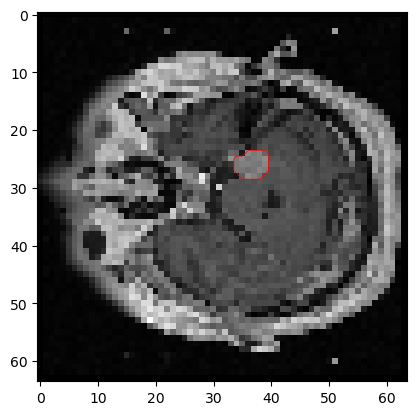

In [10]:
imgSanity(mris, masks)

Transform the lists into numpy arrays and save. 

In [11]:
mris = np.array(mris, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)



In [12]:
mris_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_t1_numpy\mris_dataset.npy"
masks_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_t1_numpy\masks_dataset.npy"
# Save as .npy files
np.save(mris_path, mris)
np.save(masks_path, masks)